<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_Mask_R_CNN%2C_GrabCut_%D0%B8_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация изображений с помощью Mask R-CNN, GrabCut и OpenCV

# Image segmentation with Mask R-CNN, GrabCut and OpenCV

Алгоритм GrabCut используется для отделения объектов переднего плана от фона.
Mask R-CNN может автоматически предсказывать как ограничивающую рамку, так и маску пиксельной сегментации каждого объекта во входном изображении. Обратной стороной является то, что маски, создаваемые Mask R-CNN, не всегда «чистые» - обычно есть небольшой фон, который «просачивается» в сегментацию переднего плана.
Для максимальной эффективности можно использовать Mask R-CNN и GrabCut  вместе.


The GrabCut algorithm is used to separate foreground objects from the background.
Mask R-CNN can automatically predict both the bounding box and the pixel segmentation mask of each object in the input image. The downside is that the masks created by Mask R-CNN are not always "clean" - there is usually a small background that "seeps" into the foreground segmentation.
For maximum efficiency, Mask R-CNN and GrabCut can be used together.

### Установим необходимые пакеты


### Install the necessary packages

In [4]:
!pip install opencv-python==4.2.0.34

### Скачиваем zip-файл с кодом


### Download the code zip file

In [2]:
!wget http://dataudt.ru/datasets/cv/Lesson_7.Img_Seg_R_CNN_GrabCut.zip
!unzip -qq Lesson_7.Img_Seg_R_CNN_GrabCut.zip
%cd /content/Lesson_7.Img_Seg_R_CNN_GrabCut/grabcut-maskrcnn

--2022-02-20 09:38:44--  http://dataudt.ru/datasets/cv/Lesson_7.Img_Seg_R_CNN_GrabCut.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59426740 (57M) [application/zip]
Saving to: ‘Lesson_7.Img_Seg_R_CNN_GrabCut.zip’

Lesson_7.Img_Seg_R_ 100%[===================>]  56.67M  18.3MB/s    in 3.1s    

2022-02-20 09:38:47 (18.3 MB/s) - ‘Lesson_7.Img_Seg_R_CNN_GrabCut.zip’ saved [59426740/59426740]

/content/Lesson_7.Img_Seg_R_CNN_GrabCut/grabcut-maskrcnn


### Импорт библиотек

### Import Packages

In [3]:
# импортируем необходимые библиотеки
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np
import imutils
import cv2
import os

### Функция для отображения изображений в блокнотах Jupyter Notebooks и Google Colab

### Function to display images in Jupyter Notebooks and Google Colab

In [5]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его 
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Наш сценарий драйвера

### Our driver script

In [6]:
# явно укажем аргументы необходимые для работы
# mask_rcnn - базовый путь к каталогу mask-rcnn
# image - путь к изображению 
# confidence - минимальная вероятность для фильтрации слабых обнаружений
# threshold - минимальный порог для сегментации маски по пикселям
# use_gpu - булево значение, указывающее на необходимость использования CUDA GPU
# iter - количество итераций GrabCut (большее значение => медленнее время выполнения) 

# explicitly specify the arguments needed to work
# mask_rcnn -  base path to mask-rcnn directory
# image - image path 
# confidence - minimum probability to filter weak detections
# threshold - minimum threshold for pixel-wise mask segmentation
# use_gpu - boolean indicating if CUDA GPU should be used
# iter -  # of GrabCut iterations (larger value => slower runtime)

args = {
	"mask_rcnn": "mask-rcnn-coco",
	"image": "example.jpg",
	"confidence": 0.5,
	"threshold": 0.3,
	"use_gpu": 0,
	"iter": 10
}

In [7]:
# загружаем метки классов COCO, на которых была обучена наша сеть Mask R-CNN
# load the COCO class labels our Mask R-CNN was trained on
labelsPath = os.path.sep.join([args["mask_rcnn"],
	"object_detection_classes_coco.txt"])
LABELS = open(labelsPath).read().strip().split("\n")

# инициализируем список цветов для представления каждой возможной метки класса
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [8]:
# получаем пути к весам Mask R-CNN и конфигурации модели
# derive the paths to the Mask R-CNN weights and model configuration
weightsPath = os.path.sep.join([args["mask_rcnn"],
	"frozen_inference_graph.pb"])
configPath = os.path.sep.join([args["mask_rcnn"],
	"mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])

# загружаем Mask R-CNN, обученную на наборе данных COCO (90 классов) с диска
# load our Mask R-CNN trained on the COCO dataset (90 classes)
# from disk
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

# проверяем, собираемся ли мы использовать GPU
# check if we are going to use GPU
if args["use_gpu"]:
    # установливаем CUDA как предпочтительный аппаратный ускоритель
	# set CUDA as the preferable backend and target
	print("[INFO] setting preferable backend and target to CUDA...")
	net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
	net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

[INFO] loading Mask R-CNN from disk...


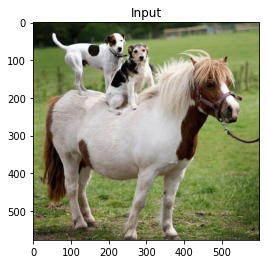

In [9]:
# загружаем наше входное изображение с диска и выводим его на наш экран
# load our input image from disk and display it to our screen
image = cv2.imread(args["image"])
image = imutils.resize(image, width=600)
plt_imshow("Input", image)

# создаем заготовку из входного изображения, а затем выполняем
# прямой проход сети Mask R-CNN, дающий нам ограничивающую рамку,
# координаты объектов на изображении вместе с 
# пиксельной сегментацией для каждого конкретного объекта
# construct a blob from the input image and then perform a
# forward pass of the Mask R-CNN, giving us (1) the bounding box
# coordinates of the objects in the image along with (2) the
# pixel-wise segmentation for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
(boxes, masks) = net.forward(["detection_out_final",
	"detection_masks"])

[INFO] showing output for 'dog'...


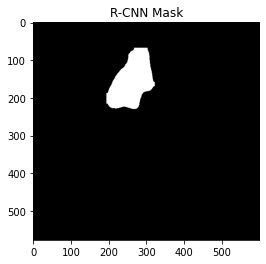

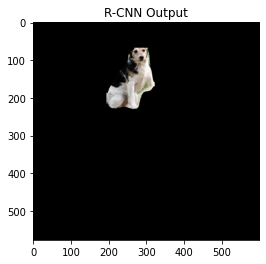

[INFO] applying GrabCut to 'dog' ROI...


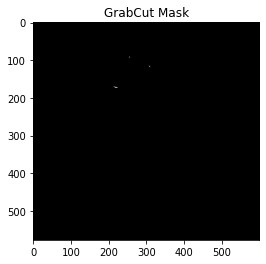

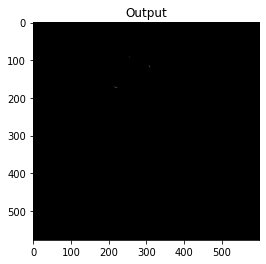

[INFO] showing output for 'dog'...


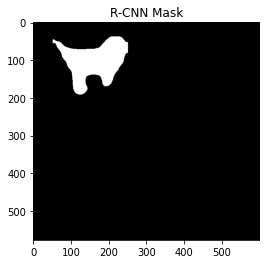

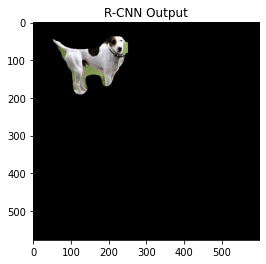

[INFO] applying GrabCut to 'dog' ROI...


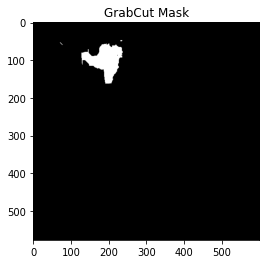

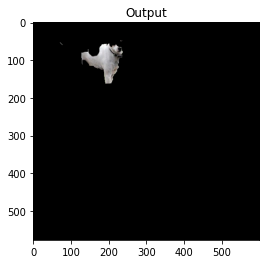

[INFO] showing output for 'horse'...


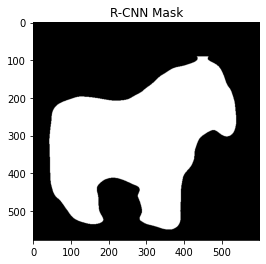

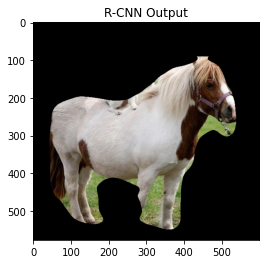

[INFO] applying GrabCut to 'horse' ROI...


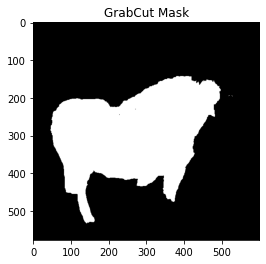

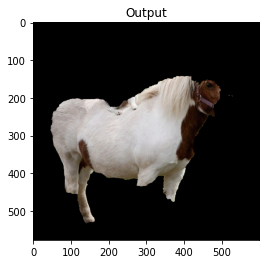

[INFO] showing output for 'cow'...


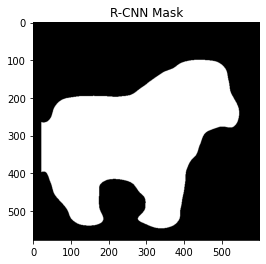

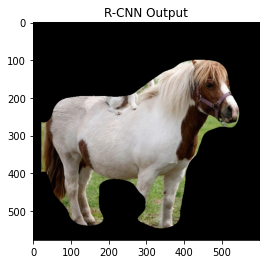

[INFO] applying GrabCut to 'cow' ROI...


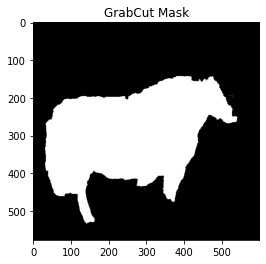

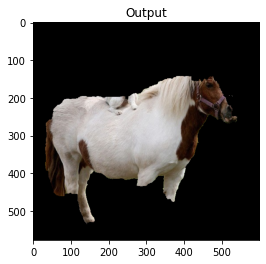

In [10]:
# проходим циклом через все обнаруженные объекты
# loop over the number of detected objects
for i in range(0, boxes.shape[2]):
    # извлекаем идентификатор класса обнаружения вместе с
    # уверенностью (т.е. вероятностью), связанной с предсказанием
	# extract the class ID of the detection along with the
	# confidence (i.e., probability) associated with the
	# prediction
	classID = int(boxes[0, 0, i, 1])
	confidence = boxes[0, 0, i, 2]

    # отфильтровываем слабые прогнозы, гарантируя обнаружение больше минимальной вероятности
	# filter out weak predictions by ensuring the detected
	# probability is greater than the minimum probability
	if confidence > args["confidence"]:
        # показываем метку класса
		# show the class label
		print("[INFO] showing output for '{}'...".format(
			LABELS[classID]))

        # нормируем координаты ограничивающего прямоугольника относительно
        # размера изображения, а затем вычисляем ширину и
        # высоту ограничивающего прямоугольника
		# scale the bounding box coordinates back relative to the
		# size of the image and then compute the width and the
		# height of the bounding box
		(H, W) = image.shape[:2]
		box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
		(startX, startY, endX, endY) = box.astype("int")
		boxW = endX - startX
		boxH = endY - startY

        # извлекаем пиксельную сегментацию объекта, изменяем размер
        # маски - она должна иметь те же размеры, что и ограничивающая
        # рамка, а затем создаем  * двоичную * маску
		# extract the pixel-wise segmentation for the object, resize
		# the mask such that it's the same dimensions as the bounding
		# box, and then finally threshold to create a *binary* mask
		mask = masks[i, classID]
		mask = cv2.resize(mask, (boxW, boxH),
			interpolation=cv2.INTER_CUBIC)
		mask = (mask > args["threshold"]).astype("uint8") * 255

        # выделяем память для нашей выходной маски Mask R-CNN и сохраняем
        # предсказанную маску Mask R-CNN в маске GrabCut    
		# allocate a memory for our output Mask R-CNN mask and store
		# the predicted Mask R-CNN mask in the GrabCut mask
		rcnnMask = np.zeros(image.shape[:2], dtype="uint8")
		rcnnMask[startY:endY, startX:endX] = mask

        # применяем побитовое И к входному изображению, чтобы показать выход
        # применения маски Mask R-CNN к изображению
		# apply a bitwise AND to the input image to show the output
		# of applying the Mask R-CNN mask to the image
		rcnnOutput = cv2.bitwise_and(image, image, mask=rcnnMask)

        # показываем вывод маски Mask R-CNN и побитовой операции И
		# show the output of the Mask R-CNN and bitwise AND operation
		plt_imshow("R-CNN Mask", rcnnMask)
		plt_imshow("R-CNN Output", rcnnOutput)
  
        # клонируем маску Mask R-CNN (чтобы мы могли использовать ее при применении GrabCut)
        # и устанавливаем любые значения маски больше нуля как
        # "вероятный передний план" (в противном случае они будут определены как "задний план") 
  		# clone the Mask R-CNN mask (so we can use it when applying
		# GrabCut) and set any mask values greater than zero to be
		# "probable foreground" (otherwise they are "definite
		# background")
		gcMask = rcnnMask.copy()
		gcMask[gcMask > 0] = cv2.GC_PR_FGD
		gcMask[gcMask == 0] = cv2.GC_BGD

        # выделяем память для двух массивов, которые алгоритм GrabCut
        # использует при сегментировании переднего и заднего плана,
        # а затем применяем GrabCut, используя маску метода сегментации
		# allocate memory for two arrays that the GrabCut algorithm
		# internally uses when segmenting the foreground from the
		# background and then apply GrabCut using the mask
		# segmentation method
		print("[INFO] applying GrabCut to '{}' ROI...".format(
			LABELS[classID]))
		fgModel = np.zeros((1, 65), dtype="float")
		bgModel = np.zeros((1, 65), dtype="float")
		(gcMask, bgModel, fgModel) = cv2.grabCut(image, gcMask,
			None, bgModel, fgModel, iterCount=args["iter"],
			mode=cv2.GC_INIT_WITH_MASK)
  
        # устанавливаем определенный и вероятный задние планы до 0
        # определенному и вероятному переднему плану присвоено значение 1
        # затем масштабируем маску в диапазоне от [0, 1] до [0, 255]
  		# set all definite background and probable background pixels
		# to 0 while definite foreground and probable foreground
		# pixels are set to 1, then scale the mask from the range
		# [0, 1] to [0, 255]
		outputMask = np.where(
			(gcMask == cv2.GC_BGD) | (gcMask == cv2.GC_PR_BGD), 0, 1)
		outputMask = (outputMask * 255).astype("uint8")

        # применяем побитовое И к изображению, используя нашу сгенерированную 
        # алгоритмом GrabCut маску для создания нашего окончательного выходного изображения
		# apply a bitwise AND to the image using our mask generated
		# by GrabCut to generate our final output image
		output = cv2.bitwise_and(image, image, mask=outputMask)

        # показываем выходную маску GrabCut, а также выходные данные после
        # применения маски GrabCut к исходному входному изображению
		# show the output GrabCut mask as well as the output of
		# applying the GrabCut mask to the original input image
		plt_imshow("GrabCut Mask", outputMask)
		plt_imshow("Output", output)